In [1]:
import pandas as pd

from fluxo.dados import Dados
from fluxo.carga_dados import CargaDados
from fluxo.limpeza_dados import LimpezaDados
from fluxo.preprocessamento import Preprocessamento
from fluxo.extracao_caracteristicas import ExtracaoCaracteristicas
from fluxo.treinamento import Treinamento
from fluxo.classificador import Classificador

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
pd.set_option('max_colwidth', 180)

## Carga de Dados

In [3]:
dados = Dados()

In [4]:
cg = CargaDados()
cg.executar(dados)

18:26:15 - Carregando dados de segmentos...
18:26:15 - 206488 registros carregados.


## Limpeza de Dados

In [5]:
lp = LimpezaDados(dados)
lp.executar(dados, 'Port.', reclassificar_nao_identificados=False)

18:26:15 - (Re)Carregando segmentos originais...
18:26:15 - Removendo segmentos nulos...
18:26:15 - 1900 segmentos nulos excluídos.
18:26:15 - Restaram 204588 segmentos não nulos.
18:26:15 - Removendo todos os segmentos do tipo Anexo...
18:26:15 - 5771 segmentos do tipo Anexo excluídos.
18:26:15 - Determinando tipos de segmento (labels) para atos do tipo Port....
18:26:15 - Tipos de segmento para atos Port.: ['Alínea', 'Artigo', 'Ementa', 'Fecho', 'Inciso', 'Não Identificado', 'Parágrafo']
18:26:15 - Excluindo segmentos dos atos que não são Port....
18:26:15 - 143909 segmentos de atos não Port. excluídos.
18:26:15 - Restaram 54908 segmentos de atos Port..
18:26:15 - Removendo segmentos não representativos para o tipo Port....
18:26:15 - 1550 segmentos não representativos excluídos.
18:26:15 - Restaram 53358 segmentos representativos.
18:26:15 - Removendo tags HTML...
18:26:15 - Removendo caracteres de escape HTML...
18:26:15 - Limpeza de dados concluída.


## Preprocessamento

In [6]:
pp = Preprocessamento()
pp.executar(dados)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/91872936504/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
18:26:16 - Convertendo caracteres para minúsculo...
18:26:16 - Removendo pontuação...
18:26:16 - Realizando tokenização...
18:26:17 - Removendo stopwords...
18:26:18 - Removendo tokens menores que 2 caracteres...
18:26:18 - Reconstruindo texto a partir dos tokens...
18:26:18 - Preprocessamento concluído.


## Extração de Características

In [7]:
ec = ExtracaoCaracteristicas(dados)
ec.executar(dados, oversampling=True)

18:26:18 - Executando vetorização TF-IDF...
18:26:21 - Executando vetorização TF-IDF para Cross-Validation...
18:26:32 - Extração de características concluída.


## Treinamento e Teste

In [8]:
t = Treinamento()

In [9]:
# Linear SVC (SVM)
estimadorSVC = LinearSVC(random_state=dados.random_state)
t.adicionar_modelo(Classificador('LinearSVC-1xR', estimadorSVC))

# Multinomial Naive Bayes 
estimadorNB = OneVsRestClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1xR', estimadorNB))

In [10]:
t.treinar_modelos(dados)

18:26:32 - Treinando modelo LinearSVC-1xR...
18:26:34 - Treinamento do modelo LinearSVC-1xR concluído.
18:26:34 - Treinando modelo MultinomialNB-1xR...
18:26:34 - Treinamento do modelo MultinomialNB-1xR concluído.


## Treinamento e Teste com Cross-Validation

In [11]:
t = Treinamento()

In [12]:
# Linear SVC (SVM)
estimadorSVC_CV = LinearSVC(random_state=dados.random_state)
t.adicionar_modelo(Classificador('LinearSVC-1xR-CV', estimadorSVC_CV))

# Multinomial Naive Bayes 
estimadorNB_CV = OneVsRestClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1xR-CV', estimadorNB_CV))

In [13]:
t.treinar_modelos(dados, cv=5)

18:26:34 - Treinando modelo LinearSVC-1xR-CV com cross-validation...
18:27:12 - Treinamento do modelo LinearSVC-1xR-CV com cross-validation concluído.
18:27:12 - Treinando modelo MultinomialNB-1xR-CV com cross-validation...
18:27:19 - Treinamento do modelo MultinomialNB-1xR-CV com cross-validation concluído.


## Apresentação de Resultados

In [14]:
resultado = pd.DataFrame(dados.metricas)
resultado.transpose()

,acuracia,precisao,revocacao,f1
LinearSVC-1xR,0.8953,0.9075,0.8783,0.8914
MultinomialNB-1xR,0.7511,0.8370,0.6881,0.7212
LinearSVC-1xR-CV,0.9197,0.9252,0.9197,0.9189
MultinomialNB-1xR-CV,0.8044,0.8133,0.8044,0.7986


In [15]:
print(resultado.transpose().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  acuracia &  precisao &  revocacao &      f1 \\
\midrule
LinearSVC-1xR        &    0.8953 &    0.9075 &     0.8783 &  0.8914 \\
MultinomialNB-1xR    &    0.7511 &    0.8370 &     0.6881 &  0.7212 \\
LinearSVC-1xR-CV     &    0.9197 &    0.9252 &     0.9197 &  0.9189 \\
MultinomialNB-1xR-CV &    0.8044 &    0.8133 &     0.8044 &  0.7986 \\
\bottomrule
\end{tabular}



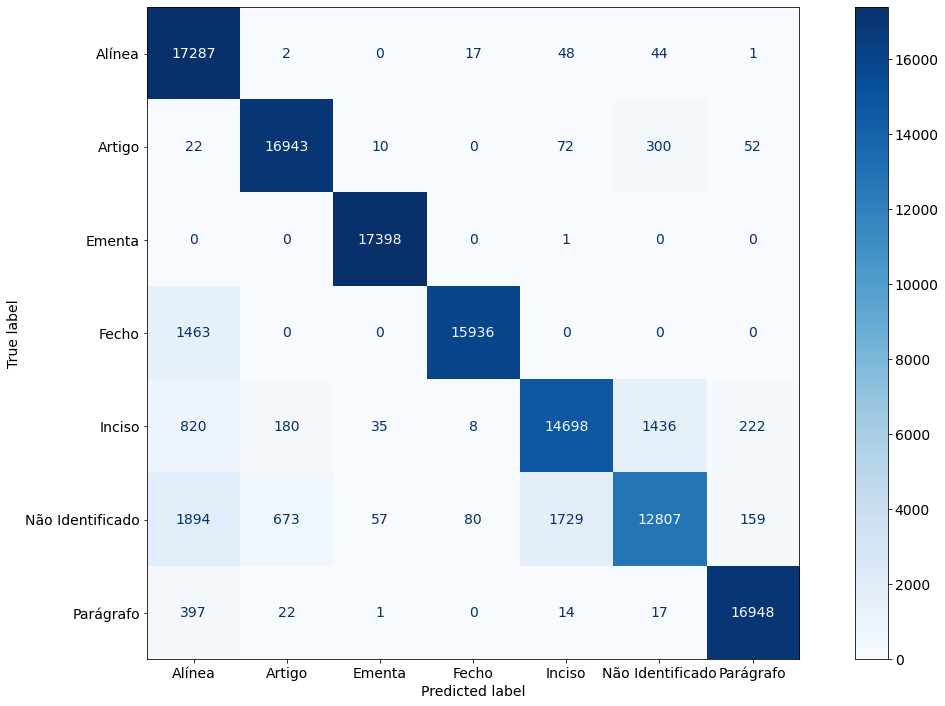

In [16]:
clf = Classificador('LinearSVC-1xR-CV', estimadorSVC_CV)
clf.treinar_com_cv(dados, cv=5)
clf.plotar_matriz_confusao(dados)